# Listmode Reconstruction

PyTomography offers PET listmode, time-of-flight reconstruction capabilities for data in the PETSIRD format. This relatively new data format is being advocated by the Emission Tomography Standardization Initiative (ETSI) to be the standard data format for all PET listmode data. More about ETSI can be found at https://etsinitiative.org/. The goal of ETSI is to standardize PET list mode data, and their current objective is to work with major vendors (such as Siemens, General Electric, United Imaging, Canon Medical Systems, Positrigo, and SynchroPET) to align all output PET data formats. 

**It should be strongly emphasized that this data format is still considered a work-in-progress**. While the data format is still relatively new, PyTomography will continue to add updated support throughout its evolution. The sample PETSIRD data file used in this tutorial was generated during the ETSI hackathon and is the output of a GATE simulation. This tutorial will demonstrate how to reconstruction this data in PyTomography.

A few caveats:
* The establishment of *all valid detector pairs* has not yet been formulated in the PETSIRD format as of yet. For now, it is assumed that all combinations of detector pairs are valid: this is important when computing normalization/sensitivity factors.
* Correction for scatter/randoms has not yet been formulated. Incorporation of these corrections can be expected in future PyTomography versions.

In [1]:
from __future__ import annotations
import sys
sys.path.append("/home/gpuvmadm/PRDdefinition/python")
import torch
import pytomography
from pytomography.metadata import ObjectMeta, PETLMProjMeta
from pytomography.projectors import PETLMSystemMatrix
from pytomography.priors import RelativeDifferencePrior
from pytomography.algorithms import BSREM, OSEM
from pytomography.io.PET import read_petsird, get_aligned_attenuation_map_GATE
import numpy as np
import matplotlib.pyplot as plt

Specify the path of the PETSIRD file, containing all listmode data:

In [2]:
path = '/home/gpuvmadm/PyTomography/notebook_testing/mIEC_ETSIPETscanner_1.petsird'

From this file we can load the `header` (yielding all required scanner metadata) as well as the `event_attributes` (yielding all measured detections)

In [3]:
header, event_attributes = read_petsird(
    path,
    read_tof=True,
    read_energy=False,
    time_block_ids=None,
)
event_det_id_1, event_det_id_2, event_det_TOF = event_attributes.T

In this modality, we need to choose our object space and voxel spacing based on the detector coordinates. 

* We can access the coordinates of all detectors using the header information of the PETSIRD data

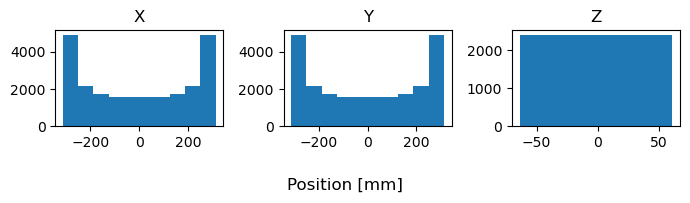

In [4]:
x_pos = [det.x for det in header.scanner.detectors]
y_pos = [det.y for det in header.scanner.detectors]
z_pos = [det.z for det in header.scanner.detectors]
fig, ax = plt.subplots(1,3,figsize=(7,2))
plt.subplot(131)
plt.hist(x_pos)
plt.title('X')
plt.subplot(132)
plt.hist(y_pos)
plt.title('Y')
plt.subplot(133)
plt.hist(z_pos)
plt.title('Z')
fig.supxlabel('Position [mm]')
fig.tight_layout()


Based on this histogram, we'll choose a reconstruction region of shape (128,128,56) with voxel spacing of 2.5mm

In [5]:
dr = (2.5, 2.5, 2.5)
shape = (128,128,56)
object_meta = ObjectMeta(dr, shape)
proj_meta = PETLMProjMeta(header, tof=True)

Load attenuation map generated from the GATE simulation:

In [6]:
amap = get_aligned_attenuation_map_GATE('/home/gpuvmadm/PyTomography/notebook_testing/ETSIPET_ACmap_IEC_10cmRadius.hv', object_meta)

Now we need to define our system matrices used for forward/back projection. In PET listmode modeling, the system matrices take in detector IDs 1 (photon 1 detection) and detector IDS 2 (photon 2 detection) of the actual measured data. These correspond to lines of response (LORs). Then...

* Forward projection $g=Hf$ considers the expected number of counts along each LOR given a specific object.
* Back projection $\hat{f}=H^Tg$ draws the LORs back in object space given detected events along each LOR. Since PET listmode data is organized such that each detected LOR corresponds to 1 detected event, in image reconstruction, $g$ is a "vector of 1s".

The `event_det_TOF` data includes additional information about timing between the detection of the two photons so that LORs can be confined to certain regions in object space (as opposed to infinitely long lines). Provided the system has TOF capabilities, this can be used in reconstruction to enhance image resolution. We'll include system matrices that consider both TOF and non-TOF reconstruction.

In [7]:
system_matrix_nontof = PETLMSystemMatrix(
    event_det_id_1,
    event_det_id_2,
    object_meta,
    proj_meta,
    attenuation_map=amap,
    event_det_TOF=None,
    )

In [8]:
system_matrix_tof = PETLMSystemMatrix(
    event_det_id_1,
    event_det_id_2,
    object_meta,
    proj_meta,
    attenuation_map=amap,
    event_det_TOF=event_det_TOF,
    )

For image reconstruction we'll use `BSREM` with the `RelativeDifferencePrior`. Of note: the `projections` argument when reconstructing PET LM data **must be a tensor with the element 1 inside**. This has to do with the fact that the number of observed events along each LOR (which are listed in order) is simply 1 (hence why it was recorded).

In [9]:
prior_rdp = RelativeDifferencePrior(beta=100, gamma=2)
recon_algorithm_nontof = BSREM(
    projections=torch.tensor([1.]).to(pytomography.device),
    system_matrix=system_matrix_nontof,
    prior=prior_rdp,
)
recon_algorithm_tof = BSREM(
    projections=torch.tensor([1.]).to(pytomography.device),
    system_matrix=system_matrix_tof,
    prior=prior_rdp,
)

Now we'll reconstruct for 100 iterations using 1 subset (only 1 subset because the data is noisey)

In [10]:
recon_tof = recon_algorithm_tof(n_iters=100, n_subsets=1)

In [11]:
recon_nontof = recon_algorithm_nontof(n_iters=100, n_subsets=1)

And we can plot the reconstructed objects:

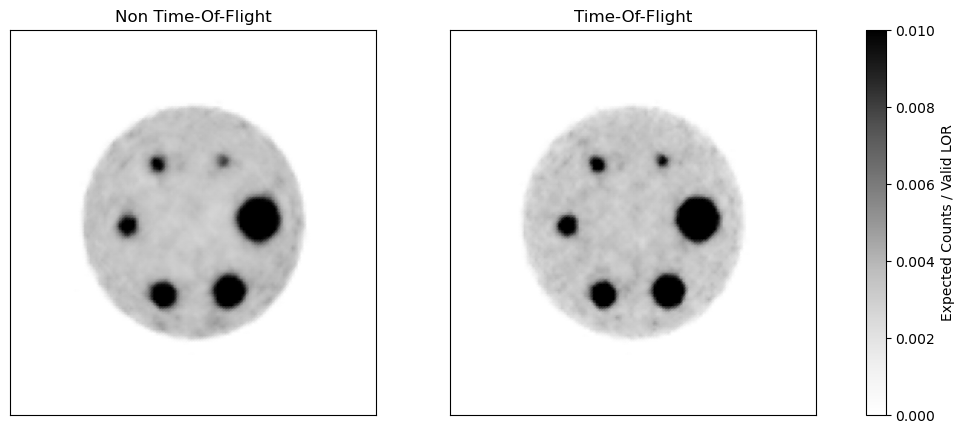

In [15]:
fig, axes = plt.subplots(1,2,figsize=(13,5))
plt.subplot(121)
c = plt.pcolormesh(recon_nontof[0,:,:,35].cpu().T, cmap='Greys', shading='gouraud', vmax=0.01)
#plt.axis('off')
plt.tick_params(axis='both', which='both', bottom=False, left = False, labelbottom=False,labelleft=False)
plt.title('Non Time-Of-Flight')
plt.subplot(122)
plt.pcolormesh(recon_tof[0,:,:,35].cpu().T, cmap='Greys', shading='gouraud', vmax=0.01)
#plt.axis('off')
plt.tick_params(axis='both', which='both', bottom=False, left = False, labelbottom=False,labelleft=False)
plt.title('Time-Of-Flight')
fig.colorbar(c, ax=axes, label='Expected Counts / Valid LOR')
plt.savefig('petsird_tof.png', dpi=300, bbox_inches='tight')

Note that the TOF has slightly higher predicted counts in the the smallest sphere, due to the higher resolution capabilities of TOF systems.